In [1]:
from stimulus import *
import torch
import numpy as np
import matplotlib.pyplot as plt
from analysis import *
import torch.utils.model_zoo as model_zoo
from tqdm.notebook import tqdm
from torchvision.models.vision_transformer import vit_b_16
from torchvision.models import ViT_B_16_Weights

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

### Generate Stimulus

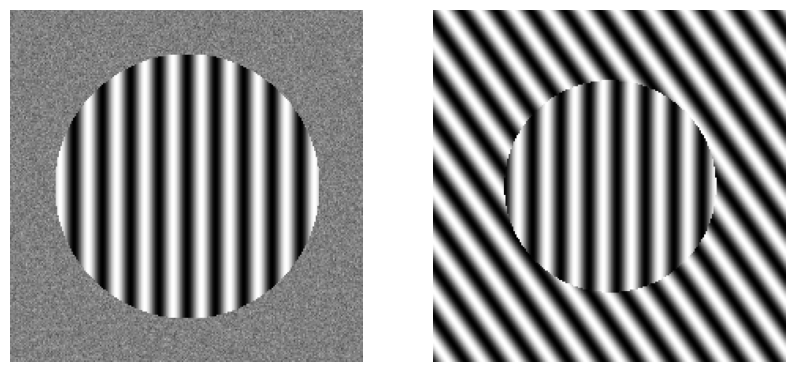

In [3]:
# vertical grating
theta = torch.tensor(np.pi * 0.5)
ornt = rgb_sine_noise(theta, rho=np.pi, freq=0.35)

# with surround
theta = torch.tensor(np.pi * 0.5)
surr = torch.tensor(np.pi * (0.5 + 0.194))
cnxt = rgb_center_surround(theta, surr, rho=np.pi * 0.5)

# plot the stimuli
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ornt = ornt.squeeze().permute(1, 2, 0)
axs[0].imshow(ornt.numpy()[:, :, 0], cmap=plt.gray())
axs[0].axis('off')

cnxt = cnxt.squeeze().permute(1, 2, 0)
axs[1].imshow(cnxt.numpy()[:, :, 0], cmap=plt.gray())
axs[1].axis('off')
plt.show()

### Compute Fisher Information (AlexNet)

In [4]:
model_urls = {'alexnet': 'http://download.pytorch.org/models/alexnet-owt-4df8aa71.pth', }
alex_net = AlexNet(None)
_ = alex_net.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
_ = alex_net.eval().to(DEVICE)

grating stimulus (noise surround)

In [5]:
n_iter = 512
all_fisher = []
for idx in tqdm(range(n_iter)):
    # set stimulus parameter
    rho = np.random.uniform(0, np.pi)
    freq = np.random.uniform(0.25, 0.45)
    stim_gen = lambda theta: rgb_sine_noise(theta, rho=rho, freq=freq).to(DEVICE)
    alex_net.generator = stim_gen

    # compute fisher information
    theta, fisher = compute_fisher(alex_net, normalize=True)
    all_fisher.append(fisher)

  0%|          | 0/512 [00:00<?, ?it/s]

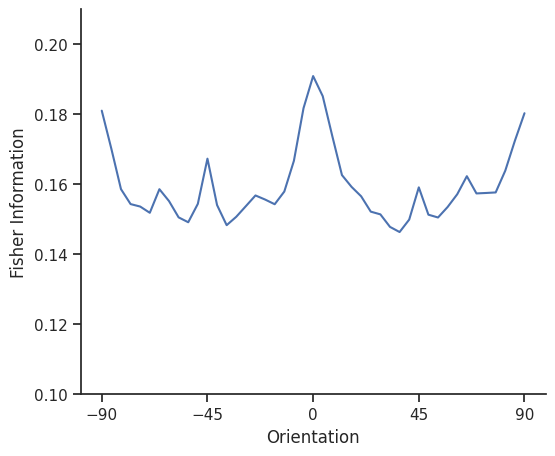

In [6]:
fisher = np.stack(all_fisher, axis=0)
avg_fisher = np.mean(fisher, axis=0)
std_fisher = np.std(fisher, axis=0)

fig = plt.figure(figsize=(6, 5))
plt.plot(theta, avg_fisher)
plt.ylim([0.10, 0.21])
plt.xlabel('Orientation')
plt.ylabel('Fisher Information')
plt.xticks(np.arange(-90, 91, 45))
plt.show()

with surround context (+35 deg)

In [7]:
n_iter = 512
all_fisher = []

# +35 deg
surround = torch.tensor(np.pi * (0.5 + 0.194))
for idx in tqdm(range(n_iter)):
    # set stimulus parameter
    rho = np.random.uniform(0, np.pi)
    freq = np.random.uniform(0.25, 0.45)
    stim_gen = lambda theta: rgb_center_surround(theta, surround,
                                                 rho=rho, freq=freq).to(DEVICE)
    alex_net.generator = stim_gen

    # compute fisher information
    theta, fisher = compute_fisher(alex_net, normalize=True)
    all_fisher.append(fisher)

  0%|          | 0/512 [00:00<?, ?it/s]

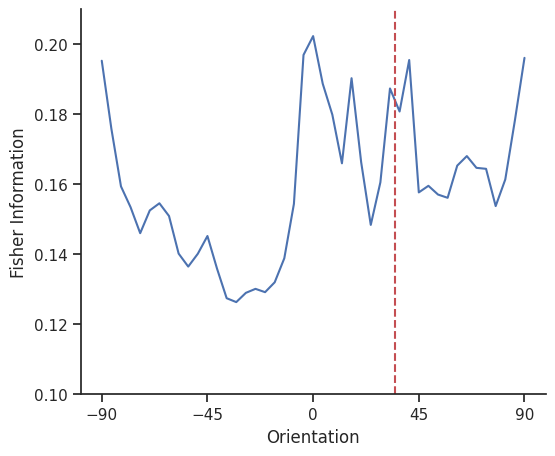

In [8]:
fisher = np.stack(all_fisher, axis=0)
avg_fisher = np.mean(fisher, axis=0)
std_fisher = np.std(fisher, axis=0)

fig = plt.figure(figsize=(6, 5))
plt.plot(theta, avg_fisher)
plt.ylim([0.10, 0.21])
plt.axvline(35, color='r', linestyle='--')
plt.xlabel('Orientation')
plt.ylabel('Fisher Information')
plt.xticks(np.arange(-90, 91, 45))
plt.show()

with surround context (-35 deg)

In [9]:
n_iter = 512
all_fisher = []

# -35 deg
surround = torch.tensor(np.pi * (0.5 - 0.194))
for idx in tqdm(range(n_iter)):
    # set stimulus parameter
    rho = np.random.uniform(0, np.pi)
    freq = np.random.uniform(0.25, 0.45)
    stim_gen = lambda theta: rgb_center_surround(theta, surround,
                                                 rho=rho, freq=freq).to(DEVICE)
    alex_net.generator = stim_gen

    # compute fisher information
    theta, fisher = compute_fisher(alex_net, normalize=True)
    all_fisher.append(fisher)

  0%|          | 0/512 [00:00<?, ?it/s]

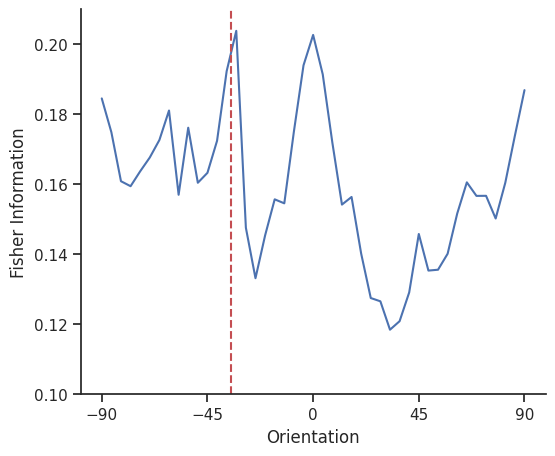

In [10]:
fisher = np.stack(all_fisher, axis=0)
avg_fisher = np.mean(fisher, axis=0)
std_fisher = np.std(fisher, axis=0)

fig = plt.figure(figsize=(6, 5))
plt.plot(theta, avg_fisher)
plt.ylim([0.10, 0.21])
plt.axvline(x=-35, color='r', linestyle='--')
plt.xlabel('Orientation')
plt.ylabel('Fisher Information')
plt.xticks(np.arange(-90, 91, 45))
plt.show()

### Compute Fisher Information (VGG 16)

In [3]:
vgg_model = VGG16(None)
model_url = 'https://download.pytorch.org/models/vgg16-397923af.pth'
_ = vgg_model.load_state_dict(model_zoo.load_url(model_url))
_ = vgg_model.eval().to(DEVICE)

In [4]:
n_iter = 128
all_fisher = []
for idx in tqdm(range(n_iter)):
    # set stimulus parameter
    rho = np.random.uniform(0, np.pi)
    freq = np.random.uniform(0.25, 0.45)
    stim_gen = lambda theta: rgb_sine_noise(theta, rho=rho, freq=freq).to(DEVICE)
    vgg_model.generator = stim_gen

    # compute fisher information
    theta, fisher = compute_fisher(vgg_model, normalize=True)
    all_fisher.append(fisher)

  0%|          | 0/128 [00:00<?, ?it/s]

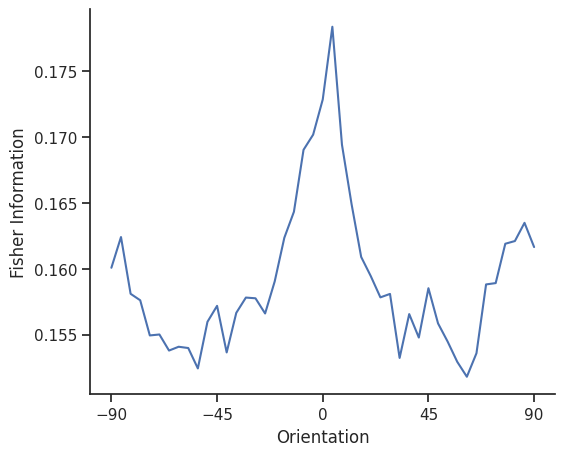

In [5]:
fisher = np.stack(all_fisher, axis=0)
avg_fisher = np.mean(fisher, axis=0)
std_fisher = np.std(fisher, axis=0)

fig = plt.figure(figsize=(6, 5))
plt.plot(theta, avg_fisher)
plt.xlabel('Orientation')
plt.ylabel('Fisher Information')
plt.xticks(np.arange(-90, 91, 45))
plt.show()

Surround Effect (+35 deg)

In [6]:
n_iter = 128
all_fisher = []

# +35 deg
surround = torch.tensor(np.pi * (0.5 + 0.194))
for idx in tqdm(range(n_iter)):
    # set stimulus parameter
    rho = np.random.uniform(0, np.pi)
    freq = np.random.uniform(0.25, 0.45)
    stim_gen = lambda theta: rgb_center_surround(theta, surround,
                                                 rho=rho, freq=freq).to(DEVICE)
    vgg_model.generator = stim_gen

    # compute fisher information
    theta, fisher = compute_fisher(vgg_model, normalize=True)
    all_fisher.append(fisher)

  0%|          | 0/128 [00:00<?, ?it/s]

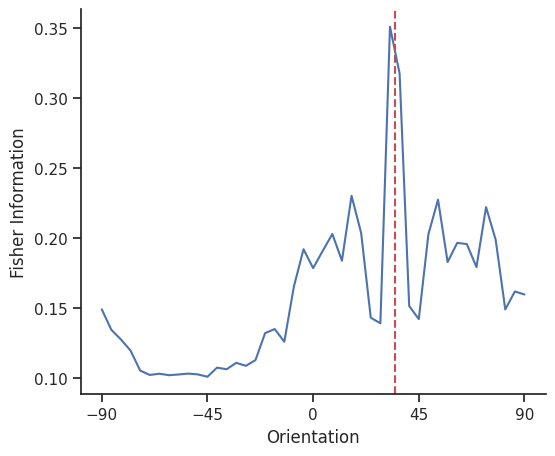

In [7]:
fisher = np.stack(all_fisher, axis=0)
avg_fisher = np.mean(fisher, axis=0)
std_fisher = np.std(fisher, axis=0)

fig = plt.figure(figsize=(6, 5))
plt.plot(theta, avg_fisher)
plt.axvline(35, color='r', linestyle='--')
plt.xlabel('Orientation')
plt.ylabel('Fisher Information')
plt.xticks(np.arange(-90, 91, 45))
plt.show()

Surround Effect (-35 deg)

In [8]:
n_iter = 128
all_fisher = []

# -35 deg
surround = torch.tensor(np.pi * (0.5 - 0.194))
for idx in tqdm(range(n_iter)):
    # set stimulus parameter
    rho = np.random.uniform(0, np.pi)
    freq = np.random.uniform(0.25, 0.45)
    stim_gen = lambda theta: rgb_center_surround(theta, surround,
                                                 rho=rho, freq=freq).to(DEVICE)
    vgg_model.generator = stim_gen

    # compute fisher information
    theta, fisher = compute_fisher(vgg_model, normalize=True)
    all_fisher.append(fisher)

  0%|          | 0/128 [00:00<?, ?it/s]

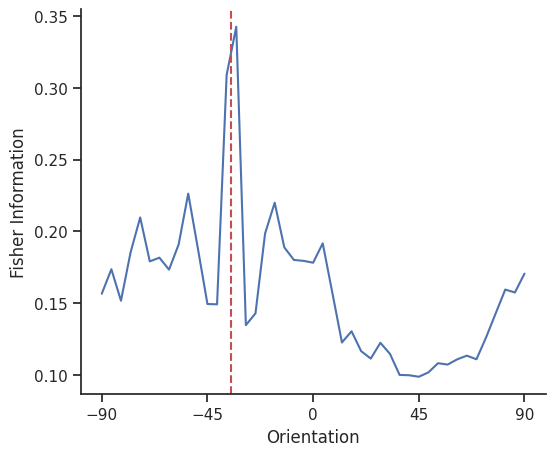

In [15]:
fisher = np.stack(all_fisher, axis=0)
avg_fisher = np.mean(fisher, axis=0)
std_fisher = np.std(fisher, axis=0)

fig = plt.figure(figsize=(6, 5))
plt.plot(theta, avg_fisher)
plt.axvline(x=-35, color='r', linestyle='--')
plt.xlabel('Orientation')
plt.ylabel('Fisher Information')
plt.xticks(np.arange(-90, 91, 45))
plt.show()